In [ ]:
# -*- coding: utf-8 -*-
# 文件名: solve_q2_by_risk_coefficient_mp.py
# 功能: 通过调整风险系数a，生成一系列候选最优解（CPU多进程并行版）。
# 版本: v2.0 - Multiprocessing Enabled

import pandas as pd
import numpy as np
import os
import re
import random
import copy
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import multiprocessing # <-- 核心改动 1: 导入多进程库

# --- 1. 【核心配置区】 ---

# --- CPU核心数设置 ---
# 设置为 0 或 None 时，将自动使用所有可用的CPU核心。
# 您可以手动设置为任何正整数，例如 4, 8, 16, 20 等。
NUM_CORES = 40 # <--- 在这里修改使用的CPU核心数

# --- 风险系数 a ---
# 建议取值: 0.1, 0.3, 0.5, 0.7, 0.9
RISK_A_COEFFICIENT = 0.7 # <--- 在这里修改风险系数a (0.0 到 1.0之间)

# --- ---------------- ---


# (1) 遗传算法参数
POP_SIZE_PER_SUBPOP = 50
NUM_POPULATIONS = 5
MAX_GEN = 200
CX_PROB = 0.8
MUT_PROB = 0.2
TOURNAMENT_SIZE = 3
ELITISM_SIZE = 5

# (2) 多种群特定参数
MIGRATION_INTERVAL = 25
MIGRATION_SIZE = 3

# (3) 问题二特定参数
NUM_SCENARIOS = 100
YEARS = list(range(2024, 2031))

# --- 2. 数据加载与情景生成 (函数未改动) ---
def load_and_prepare_data(data_path):
    try:
        print("（1）正在读取Excel文件...")
        path_f1 = data_path / '附件1.xlsx'
        path_f2 = data_path / '附件2.xlsx'

        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地')
        crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据')
        past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')

        for df in [plots_df, crops_info_df, stats_df, past_planting_df]:
            df.columns = df.columns.str.strip()

        params = {}
        params['I_plots'] = sorted(plots_df['地块名称'].tolist())
        params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩']))
        params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))

        params['J_crops'] = sorted(crops_info_df['作物名称'].dropna().unique().tolist())
        params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型']))
        params['J_bean'] = [j for j, ctype in params['P_crop_type'].items() if isinstance(ctype, str) and '豆' in ctype]

        params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
        for _, row in past_planting_df.iterrows():
            plot, crop = row['种植地块'], row['作物名称']
            season = row.get('种植季节', 1)
            if plot in params['I_plots']:
                params['P_past'][plot][season] = crop

        def clean_and_convert_price(value):
            if isinstance(value, str) and any(c in value for c in '-–—'):
                parts = re.split(r'[-–—]', value.strip())
                try: return (float(parts[0]) + float(parts[1])) / 2
                except (ValueError, IndexError): return np.nan
            return pd.to_numeric(value, errors='coerce')

        stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price)
        stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
        
        params['P_yield_base'], params['P_cost_base'], params['P_price_base'] = {}, {}, {}
        for _, row in stats_df.iterrows():
            key = (row['作物名称'], row['地块类型'])
            params['P_cost_base'][key] = row['种植成本/(元/亩)']
            params['P_yield_base'][key] = row['亩产量/斤']
            params['P_price_base'][key] = row['销售单价/(元/斤)']

        params['P_demand_base'] = {j: 0 for j in params['J_crops']}
        merged_df = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称', how='left')
        
        for crop in params['J_crops']:
            crop_plantings = merged_df[merged_df['作物名称'] == crop]
            total_yield = 0
            if not crop_plantings.empty:
                for _, row in crop_plantings.iterrows():
                    area = row.get('种植面积/亩', params['P_area'][row['种植地块']])
                    yield_val = params['P_yield_base'].get((crop, row['地块类型']), 0)
                    total_yield += area * yield_val
            params['P_demand_base'][crop] = total_yield

        params['S_suitability'] = {}
        restricted_veg = ['大白菜', '白萝卜', '红萝卜']
        for i in params['I_plots']:
            plot_t = params['P_plot_type'].get(i, '')
            for j in params['J_crops']:
                crop_t = params['P_crop_type'].get(j, '')
                is_veg = '蔬菜' in str(crop_t)
                for k in [1, 2]:
                    suitable = 0
                    if plot_t in ['平旱地', '梯田', '山坡地'] and ('粮食' in str(crop_t) or j in params['J_bean']) and k == 1: suitable = 1
                    elif plot_t == '水浇地':
                        if '水稻' in j and k == 1: suitable = 1
                        elif is_veg:
                            if j not in restricted_veg and k == 1: suitable = 1
                            elif j in restricted_veg and k == 2: suitable = 1
                    elif plot_t == '普通大棚':
                        if is_veg and j not in restricted_veg and k == 1: suitable = 1
                        elif '食用菌' in str(crop_t) and k == 2: suitable = 1
                    elif plot_t == '智慧大棚' and is_veg and j not in restricted_veg: suitable = 1
                    params['S_suitability'][(i, j, k)] = suitable
        
        print(" -> 基础数据参数准备完成。")
        return params
    except Exception as e:
        print(f"错误: 加载数据失败: {e}"); raise

def generate_scenarios(params, num_scenarios):
    print(f"（2）正在生成 {num_scenarios} 个未来情景...")
    scenarios = []
    crop_types = params['P_crop_type']
    base_demand = params['P_demand_base']
    base_yield = params['P_yield_base']
    base_cost = params['P_cost_base']
    base_price = params['P_price_base']
    for _ in tqdm(range(num_scenarios), desc="生成情景"):
        scenario = {
            'P_demand': {y: {} for y in YEARS}, 'P_yield': {y: {} for y in YEARS},
            'P_cost': {y: {} for y in YEARS}, 'P_price': {y: {} for y in YEARS},
        }
        temp_demand = copy.deepcopy(base_demand)
        temp_cost = copy.deepcopy(base_cost)
        temp_price = copy.deepcopy(base_price)
        for y in YEARS:
            for crop in params['J_crops']:
                if y > 2024:
                    if crop in ['小麦', '玉米']: growth_rate = np.random.uniform(0.05, 0.10)
                    else: growth_rate = np.random.uniform(-0.05, 0.05)
                    temp_demand[crop] *= (1 + growth_rate)
            scenario['P_demand'][y] = copy.deepcopy(temp_demand)
            for key, b_yield in base_yield.items():
                scenario['P_yield'][y][key] = b_yield * (1 + np.random.uniform(-0.10, 0.10))
            if y > 2024:
                for key in temp_cost: temp_cost[key] *= (1 + np.random.normal(0.05, 0.01))
            scenario['P_cost'][y] = copy.deepcopy(temp_cost)
            if y > 2024:
                for key in temp_price:
                    crop, _ = key
                    ctype = crop_types.get(crop, '')
                    if '蔬菜' in str(ctype): temp_price[key] *= (1 + np.random.normal(0.05, 0.02))
                    elif '食用菌' in str(ctype): temp_price[key] *= (1 - (0.05 if crop == '羊肚菌' else np.random.uniform(0.01, 0.05)))
            scenario['P_price'][y] = copy.deepcopy(temp_price)
        scenarios.append(scenario)
    print(" -> 情景生成完毕。")
    return scenarios

# --- 3. 遗传算法核心函数 (函数未改动) ---
def create_initial_solution(params):
    solution = {y: {k: {i: None for i in params['I_plots']} for k in [1, 2]} for y in YEARS}
    for y in YEARS:
        for i in params['I_plots']:
            for k in [1, 2]:
                possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1]
                if possible_crops:
                    solution[y][k][i] = random.choice(possible_crops)
    return repair_solution(solution, params)

def repair_solution(solution, params):
    def get_crops_in_year(sol, y, i):
        crops = set()
        if y == 2023:
            for k in [1, 2]:
                crop = params['P_past'].get(i, {}).get(k)
                if crop: crops.add(crop)
        elif y in sol:
            for k in [1, 2]:
                crop = sol.get(y, {}).get(k, {}).get(i)
                if crop: crops.add(crop)
        return list(crops)
    for i in params['I_plots']:
        for y in YEARS:
            crops_last_year = get_crops_in_year(solution, y - 1, i)
            for k in [1, 2]:
                crop_this_season = solution[y][k][i]
                if crop_this_season and crop_this_season in crops_last_year:
                    possible_replacements = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1 and j not in crops_last_year]
                    solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
    for i in params['I_plots']:
        all_years = [2023] + YEARS
        for idx in range(len(all_years) - 2):
            window = all_years[idx:idx+3]
            contains_bean = any(c in params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
            if not contains_bean:
                y_fix = random.choice([y for y in window if y > 2023])
                k_fix = 1
                crops_last_year = get_crops_in_year(solution, y_fix - 1, i)
                possible_beans = [b for b in params['J_bean'] if params['S_suitability'].get((i, b, k_fix), 0) == 1 and b not in crops_last_year]
                if possible_beans:
                    solution[y_fix][k_fix][i] = random.choice(possible_beans)
    return solution

def crossover(p1, p2, params):
    child = copy.deepcopy(p1)
    for i in params['I_plots']:
        if random.random() < 0.5:
            for y in YEARS:
                for k in [1, 2]:
                    child[y][k][i] = p2[y][k][i]
    return child

def mutate(solution, params):
    mut_sol = copy.deepcopy(solution)
    for _ in range(random.randint(1, 5)):
        y = random.choice(YEARS)
        i = random.choice(params['I_plots'])
        k = random.choice([1, 2])
        possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1]
        if possible_crops:
            mut_sol[y][k][i] = random.choice(possible_crops)
    return mut_sol

def calculate_profits_for_solution(solution, params, scenarios):
    profits = []
    for scenario in scenarios:
        total_revenue, total_cost = 0, 0
        total_production_by_crop = defaultdict(float)
        for y in YEARS:
            for i in params['I_plots']:
                plot_type = params['P_plot_type'][i]
                area = params['P_area'][i]
                for k in [1, 2]:
                    crop = solution[y][k].get(i)
                    if not crop: continue
                    key = (crop, plot_type)
                    cost = scenario['P_cost'][y].get(key, 9e9)
                    yield_val = scenario['P_yield'][y].get(key, 0)
                    if cost > 1e9: continue
                    total_cost += area * cost
                    total_production_by_crop[crop] += area * yield_val
        for crop, production in total_production_by_crop.items():
            total_demand_7_years = sum(scenario['P_demand'][y].get(crop, 0) for y in YEARS)
            all_prices = [p for y_prices in scenario['P_price'].values() for (c, pt), p in y_prices.items() if c == crop and p > 0]
            price = np.mean(all_prices) if all_prices else 0
            if price > 0:
                normal_qty = min(production, total_demand_7_years)
                over_qty = production - normal_qty
                total_revenue += (normal_qty * price) + (over_qty * price * 0.5)
        profits.append(total_revenue - total_cost)
    return profits

# <-- 核心改动 2: 将评估函数定义在顶层，并创建包装函数以便多进程调用 ---
def evaluate_fitness_q2(solution, params, scenarios, a_coeff):
    profits = calculate_profits_for_solution(solution, params, scenarios)
    valid_profits = [p for p in profits if not np.isnan(p)]
    if not valid_profits: return -1e9

    expected_profit = np.mean(valid_profits)
    risk = np.std(valid_profits)
    
    fitness = a_coeff * expected_profit - (1 - a_coeff) * risk
    return fitness

def evaluate_fitness_wrapper(args):
    """
    这是一个包装函数，用于解包参数并调用原始的适应度函数。
    多进程的 starmap 方法需要一个只接受一个参数（元组）的函数。
    """
    solution, params, scenarios, a_coeff = args
    return evaluate_fitness_q2(solution, params, scenarios, a_coeff)

# --- 4. 多种群遗传算法(MPGA)运行器 (多进程版) ---
def run_mpga(params, scenarios, a_coeff, pool): # <-- 核心改动 3: 接收一个进程池作为参数
    print(f"\n--- 开始执行MPGA (风险系数 a = {a_coeff}) ---")
    populations = [[create_initial_solution(params) for _ in range(POP_SIZE_PER_SUBPOP)] for _ in range(NUM_POPULATIONS)]
    best_solution_overall, best_fitness_overall = None, -np.inf
    convergence_history = []
    
    for gen in tqdm(range(MAX_GEN), desc=f"MPGA进化中 (a={a_coeff})"):
        all_fitnesses = []
        for i in range(NUM_POPULATIONS):
            pop = populations[i]
            
            # --- 核心改动 4: 使用进程池并行计算适应度 ---
            # 1. 准备传递给每个进程的参数列表
            task_args = [(sol, params, scenarios, a_coeff) for sol in pop]
            
            # 2. 使用 starmap 将任务分配给进程池，并等待结果
            fitnesses = pool.starmap(evaluate_fitness_q2, task_args)
            # --- ------------------------------------ ---
            
            all_fitnesses.append(fitnesses)
            best_fit_in_pop = np.max(fitnesses)
            if best_fit_in_pop > best_fitness_overall:
                best_fitness_overall = best_fit_in_pop
                best_solution_overall = copy.deepcopy(pop[np.argmax(fitnesses)])
            
            elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]
            new_pop = [pop[idx] for idx in elite_indices]
            
            while len(new_pop) < POP_SIZE_PER_SUBPOP:
                def tournament_selection(p, f, k):
                    best = random.randrange(len(p))
                    for _ in range(k - 1):
                        idx = random.randrange(len(p))
                        if f[idx] > f[best]: best = idx
                    return p[best]
                p1 = tournament_selection(pop, fitnesses, TOURNAMENT_SIZE)
                p2 = tournament_selection(pop, fitnesses, TOURNAMENT_SIZE)
                child = crossover(p1, p2, params) if random.random() < CX_PROB else copy.deepcopy(p1)
                if random.random() < MUT_PROB:
                    child = mutate(child, params)
                new_pop.append(repair_solution(child, params))
            populations[i] = new_pop
        
        if gen > 0 and gen % MIGRATION_INTERVAL == 0:
            for i in range(NUM_POPULATIONS):
                target_pop_idx = (i + 1) % NUM_POPULATIONS
                best_indices_current = np.argsort(all_fitnesses[i])[-MIGRATION_SIZE:]
                migrants = [populations[i][idx] for idx in best_indices_current]
                worst_indices_target = np.argsort(all_fitnesses[target_pop_idx])[:MIGRATION_SIZE]
                for j in range(MIGRATION_SIZE):
                    populations[target_pop_idx][worst_indices_target[j]] = copy.deepcopy(migrants[j])
        
        convergence_history.append({'Generation': gen, 'Best_Fitness': best_fitness_overall})
    
    print(f"\n--- MPGA (a={a_coeff}) 优化完成 ---")
    return best_solution_overall, best_fitness_overall, convergence_history

# --- 5. 主程序 ---
if __name__ == '__main__':
    # <-- 核心改动 5: 设置CPU核心数并创建进程池 ---
    # 如果 NUM_CORES 设置为 0 或 None，则自动使用所有核心
    num_cores_to_use = NUM_CORES if NUM_CORES and NUM_CORES > 0 else multiprocessing.cpu_count()
    print(f"--- 检测到 {multiprocessing.cpu_count()} 个CPU核心，将启动 {num_cores_to_use} 个进程进行并行计算 ---")
    
    # 创建一个进程池，程序结束时会自动关闭
    with multiprocessing.Pool(processes=num_cores_to_use) as pool:
        try:
            a = RISK_A_COEFFICIENT
            if not (0.0 <= a <= 1.0):
                raise ValueError("错误：风险系数 a 必须在 0.0 和 1.0 之间。")

            script_dir = Path(__file__).parent if "__file__" in locals() else Path.cwd()
            data_path = script_dir / '..' / 'Data'
            output_dir = script_dir / 'Result'
            output_dir.mkdir(parents=True, exist_ok=True)
            
            print(f"脚本运行目录: {script_dir}")
            print(f"数据读取路径: {data_path}")
            print(f"结果输出路径: {output_dir}")
            
            base_params = load_and_prepare_data(data_path)
            scenarios = generate_scenarios(base_params, NUM_SCENARIOS)

            # 将进程池 'pool' 传递给主函数
            best_solution, best_fitness, history = run_mpga(base_params, scenarios, a, pool)
            
            print(f"\n求解完成 (风险系数 a = {a})。")
            print(f" -> 最优适应度值: {best_fitness:,.2f}")

            if best_solution:
                file_suffix = f"a{str(a).replace('.', '')}"

                # (1) 保存最终方案
                output_list = []
                for y in sorted(best_solution.keys()):
                    for k in sorted(best_solution[y].keys()):
                        for i in sorted(best_solution[y][k].keys()):
                            crop = best_solution[y][k][i]
                            if crop:
                                output_list.append({'年份': y, '季节': k, '地块编号': i, '作物名称': crop, '种植面积（亩）': base_params['P_area'][i]})
                result_df = pd.DataFrame(output_list)
                file_path = output_dir / f'result2_{file_suffix}.xlsx'
                result_df.to_excel(file_path, index=False)
                print(f"最优方案已保存至: {file_path}")

                # (2) 保存收敛过程数据
                history_df = pd.DataFrame(history)
                log_path = output_dir / f'log_{file_suffix}.csv'
                history_df.to_csv(log_path, index=False)
                print(f"收敛过程日志已保存至: {log_path}")

                # (3) 保存最优方案的利润分布
                final_profits = calculate_profits_for_solution(best_solution, base_params, scenarios)
                profits_df = pd.DataFrame(final_profits, columns=['Profit'])
                profits_path = output_dir / f'profits_{file_suffix}.csv'
                profits_df.to_csv(profits_path, index=False)
                print(f"最优方案利润分布已保存至: {profits_path}")
            else:
                print("未能找到有效解。")

        except Exception as e:
            print(f"\n程序主流程发生错误: {e}")
            import traceback
            traceback.print_exc()


脚本运行目录: c:\Users\86185\Desktop\2024C\4问题二
数据读取路径: c:\Users\86185\Desktop\2024C\4问题二\..\Data
结果输出路径: c:\Users\86185\Desktop\2024C\4问题二\Result
（1）正在读取Excel文件...
 -> 基础数据参数准备完成。
（2）正在生成 100 个未来情景...


生成情景: 100%|██████████| 100/100 [00:01<00:00, 61.11it/s]


 -> 情景生成完毕。

--- 开始执行多种群遗传算法 (MPGA) ---


MPGA进化中: 100%|██████████| 200/200 [6:27:05<00:00, 116.13s/it]  



--- MPGA 优化完成 ---

求解完成。
 -> 最优方案的夏普比率: 394.5632
最优方案已保存至: c:\Users\86185\Desktop\2024C\4问题二\Result\result2.xlsx
收敛过程日志已保存至: c:\Users\86185\Desktop\2024C\4问题二\Result\mpga_log.csv
最优方案利润分布已保存至: c:\Users\86185\Desktop\2024C\4问题二\Result\best_solution_profits.csv


In [11]:
# -*- coding: utf-8 -*-
# 文件名: solve_q2_simple_ga.py
# 功能: 采用第一问的简单遗传算法(GA)框架，求解第二问，用于与MPGA进行结果对比。
# 版本: Q2_SimpleGA_Compare

import pandas as pd
import numpy as np
import os
import re
import random
import copy
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

# --- 1. 模型核心参数配置区 ---

# (1) 简单遗传算法参数 (与Q1保持一致)
POP_SIZE = 100                 # 【注意】这里是单种群的总大小
MAX_GEN = 200
CX_PROB = 0.8
MUT_PROB = 0.2
TOURNAMENT_SIZE = 3
ELITISM_SIZE = 5

# (2) 问题二特定参数
NUM_SCENARIOS = 100
YEARS = list(range(2024, 2031))

# --- 2. 数据加载与情景生成 (函数已折叠，与MPGA版本完全相同) ---
def load_and_prepare_data(data_path):
    # 此函数内容与 solve_q2_mpga.py 中的版本完全相同
    try:
        print("（1）正在读取Excel文件...")
        path_f1 = data_path / '附件1.xlsx'
        path_f2 = data_path / '附件2.xlsx'

        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地')
        crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据')
        past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')

        for df in [plots_df, crops_info_df, stats_df, past_planting_df]:
            df.columns = df.columns.str.strip()

        params = {}
        params['I_plots'] = sorted(plots_df['地块名称'].tolist())
        params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩']))
        params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))

        params['J_crops'] = sorted(crops_info_df['作物名称'].dropna().unique().tolist())
        params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型']))
        params['J_bean'] = [j for j, ctype in params['P_crop_type'].items() if isinstance(ctype, str) and '豆' in ctype]

        params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
        for _, row in past_planting_df.iterrows():
            plot, crop = row['种植地块'], row['作物名称']
            season = row.get('种植季节', 1)
            if plot in params['I_plots']:
                params['P_past'][plot][season] = crop

        def clean_and_convert_price(value):
            if isinstance(value, str) and any(c in value for c in '-–—'):
                parts = re.split(r'[-–—]', value.strip())
                try: return (float(parts[0]) + float(parts[1])) / 2
                except (ValueError, IndexError): return np.nan
            return pd.to_numeric(value, errors='coerce')

        stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price)
        stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
        
        params['P_yield_base'], params['P_cost_base'], params['P_price_base'] = {}, {}, {}
        for _, row in stats_df.iterrows():
            key = (row['作物名称'], row['地块类型'])
            params['P_cost_base'][key] = row['种植成本/(元/亩)']
            params['P_yield_base'][key] = row['亩产量/斤']
            params['P_price_base'][key] = row['销售单价/(元/斤)']

        params['P_demand_base'] = {j: 0 for j in params['J_crops']}
        merged_df = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称', how='left')
        
        for crop in params['J_crops']:
            crop_plantings = merged_df[merged_df['作物名称'] == crop]
            total_yield = 0
            if not crop_plantings.empty:
                for _, row in crop_plantings.iterrows():
                    area = row.get('种植面积/亩', params['P_area'][row['种植地块']])
                    yield_val = params['P_yield_base'].get((crop, row['地块类型']), 0)
                    total_yield += area * yield_val
            params['P_demand_base'][crop] = total_yield

        params['S_suitability'] = {}
        restricted_veg = ['大白菜', '白萝卜', '红萝卜']
        for i in params['I_plots']:
            plot_t = params['P_plot_type'].get(i, '')
            for j in params['J_crops']:
                crop_t = params['P_crop_type'].get(j, '')
                is_veg = '蔬菜' in str(crop_t)
                for k in [1, 2]:
                    suitable = 0
                    if plot_t in ['平旱地', '梯田', '山坡地'] and ('粮食' in str(crop_t) or j in params['J_bean']) and k == 1: suitable = 1
                    elif plot_t == '水浇地':
                        if '水稻' in j and k == 1: suitable = 1
                        elif is_veg:
                            if j not in restricted_veg and k == 1: suitable = 1
                            elif j in restricted_veg and k == 2: suitable = 1
                    elif plot_t == '普通大棚':
                        if is_veg and j not in restricted_veg and k == 1: suitable = 1
                        elif '食用菌' in str(crop_t) and k == 2: suitable = 1
                    elif plot_t == '智慧大棚' and is_veg and j not in restricted_veg: suitable = 1
                    params['S_suitability'][(i, j, k)] = suitable
        
        print(" -> 基础数据参数准备完成。")
        return params
    except Exception as e:
        print(f"错误: 加载数据失败: {e}"); raise

def generate_scenarios(params, num_scenarios):
    # 此函数内容与 solve_q2_mpga.py 中的版本完全相同
    print(f"（2）正在生成 {num_scenarios} 个未来情景...")
    scenarios = []
    
    crop_types = params['P_crop_type']
    base_demand = params['P_demand_base']
    base_yield = params['P_yield_base']
    base_cost = params['P_cost_base']
    base_price = params['P_price_base']

    for _ in tqdm(range(num_scenarios), desc="生成情景"):
        scenario = {
            'P_demand': {y: {} for y in YEARS},
            'P_yield': {y: {} for y in YEARS},
            'P_cost': {y: {} for y in YEARS},
            'P_price': {y: {} for y in YEARS},
        }
        
        temp_demand = copy.deepcopy(base_demand)
        temp_cost = copy.deepcopy(base_cost)
        temp_price = copy.deepcopy(base_price)

        for y in YEARS:
            # (1) 预期销售量
            for crop in params['J_crops']:
                if y > 2024:
                    if crop in ['小麦', '玉米']:
                        growth_rate = np.random.uniform(0.05, 0.10)
                    else:
                        growth_rate = np.random.uniform(-0.05, 0.05)
                    temp_demand[crop] *= (1 + growth_rate)
            scenario['P_demand'][y] = copy.deepcopy(temp_demand)
            
            # (2) 亩产量
            for key, b_yield in base_yield.items():
                change = np.random.uniform(-0.10, 0.10)
                scenario['P_yield'][y][key] = b_yield * (1 + change)

            # (3) 种植成本
            if y > 2024:
                for key in temp_cost:
                    growth_rate = np.random.normal(0.05, 0.01)
                    temp_cost[key] *= (1 + growth_rate)
            scenario['P_cost'][y] = copy.deepcopy(temp_cost)

            # (4) 销售价格
            if y > 2024:
                for key in temp_price:
                    crop, _ = key
                    ctype = crop_types.get(crop, '')
                    if '粮食' in str(ctype):
                        pass 
                    elif '蔬菜' in str(ctype):
                        growth_rate = np.random.normal(0.05, 0.02)
                        temp_price[key] *= (1 + growth_rate)
                    elif '食用菌' in str(ctype):
                        decline_rate = 0.05 if crop == '羊肚菌' else np.random.uniform(0.01, 0.05)
                        temp_price[key] *= (1 - decline_rate)
            scenario['P_price'][y] = copy.deepcopy(temp_price)
        
        scenarios.append(scenario)
    print(" -> 情景生成完毕。")
    return scenarios


# --- 3. 遗传算法核心函数 (大部分与Q1/MPGA版本相同) ---
def create_initial_solution(params):
    # 此函数内容与 solve_q2_mpga.py 中的版本完全相同
    solution = {y: {k: {i: None for i in params['I_plots']} for k in [1, 2]} for y in YEARS}
    for y in YEARS:
        for i in params['I_plots']:
            for k in [1, 2]:
                possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1]
                if possible_crops:
                    solution[y][k][i] = random.choice(possible_crops)
    return repair_solution(solution, params)

def repair_solution(solution, params):
    # 此函数内容与 solve_q2_mpga.py 中的版本完全相同
    def get_crops_in_year(sol, y, i):
        crops = set()
        if y == 2023:
            for k in [1, 2]:
                crop = params['P_past'].get(i, {}).get(k)
                if crop: crops.add(crop)
        elif y in sol:
            for k in [1, 2]:
                crop = sol.get(y, {}).get(k, {}).get(i)
                if crop: crops.add(crop)
        return list(crops)

    for i in params['I_plots']:
        for y in YEARS:
            crops_last_year = get_crops_in_year(solution, y - 1, i)
            for k in [1, 2]:
                crop_this_season = solution[y][k][i]
                if crop_this_season and crop_this_season in crops_last_year:
                    possible_replacements = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1 and j not in crops_last_year]
                    solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
    
    for i in params['I_plots']:
        all_years = [2023] + YEARS
        for idx in range(len(all_years) - 2):
            window = all_years[idx:idx+3]
            contains_bean = any(c in params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
            if not contains_bean:
                y_fix = random.choice([y for y in window if y > 2023])
                k_fix = 1
                crops_last_year = get_crops_in_year(solution, y_fix - 1, i)
                possible_beans = [b for b in params['J_bean'] if params['S_suitability'].get((i, b, k_fix), 0) == 1 and b not in crops_last_year]
                if possible_beans:
                    solution[y_fix][k_fix][i] = random.choice(possible_beans)
    return solution

def crossover(p1, p2, params):
    # 此函数内容与 solve_q2_mpga.py 中的版本完全相同
    child = copy.deepcopy(p1)
    for i in params['I_plots']:
        if random.random() < 0.5:
            for y in YEARS:
                for k in [1, 2]:
                    child[y][k][i] = p2[y][k][i]
    return child

def mutate(solution, params):
    # 此函数内容与 solve_q2_mpga.py 中的版本完全相同
    mut_sol = copy.deepcopy(solution)
    for _ in range(random.randint(1, 5)):
        y = random.choice(YEARS)
        i = random.choice(params['I_plots'])
        k = random.choice([1, 2])
        possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1]
        if possible_crops:
            mut_sol[y][k][i] = random.choice(possible_crops)
    return mut_sol

def calculate_profits_for_solution(solution, params, scenarios):
    # 此函数内容与 solve_q2_mpga.py 中的版本完全相同
    profits = []
    for scenario in scenarios:
        total_revenue, total_cost = 0, 0
        total_production_by_crop = defaultdict(float)
        
        for y in YEARS:
            for i in params['I_plots']:
                plot_type = params['P_plot_type'][i]
                area = params['P_area'][i]
                for k in [1, 2]:
                    crop = solution[y][k][i]
                    if not crop: continue
                    key = (crop, plot_type)
                    cost = scenario['P_cost'][y].get(key, 9e9)
                    yield_val = scenario['P_yield'][y].get(key, 0)
                    if cost > 1e9: continue
                    total_cost += area * cost
                    total_production_by_crop[crop] += area * yield_val

        for crop, production in total_production_by_crop.items():
            total_demand_7_years = sum(scenario['P_demand'][y].get(crop, 0) for y in YEARS)
            all_prices = [p for y_prices in scenario['P_price'].values() for (c, pt), p in y_prices.items() if c == crop and p > 0]
            price = np.mean(all_prices) if all_prices else 0
            
            if price > 0:
                normal_qty = min(production, total_demand_7_years)
                over_qty = production - normal_qty
                total_revenue += (normal_qty * price) + (over_qty * price * 0.5)
        
        profits.append(total_revenue - total_cost)
    return profits

# 【关键修改】使用Q2的适应度函数
def evaluate_fitness_q2(solution, params, scenarios):
    profits = calculate_profits_for_solution(solution, params, scenarios)
    valid_profits = [p for p in profits if not np.isnan(p)]
    if not valid_profits: return -1e9

    expected_profit = np.mean(valid_profits)
    risk = np.std(valid_profits)

    if risk < 1e-6:
        return expected_profit if expected_profit > 0 else -1e9
    return expected_profit / risk


# --- 4. 简单遗传算法(GA)运行器 ---
def run_genetic_algorithm(params, scenarios):
    """
    源自Q1的简单遗传算法运行器，但使用Q2的适应度函数
    """
    print("\n--- 开始执行简单遗传算法 (Simple GA) ---")
    
    population = [create_initial_solution(params) for _ in range(POP_SIZE)]
    best_solution_overall, best_fitness_overall = None, -np.inf
    
    convergence_history = []

    for gen in tqdm(range(MAX_GEN), desc="Simple GA进化中"):
        # 【关键修改】调用Q2的适应度函数，并传入scenarios
        fitnesses = [evaluate_fitness_q2(sol, params, scenarios) for sol in population]

        best_fit_in_gen = np.max(fitnesses)
        if best_fit_in_gen > best_fitness_overall:
            best_fitness_overall = best_fit_in_gen
            best_solution_overall = copy.deepcopy(population[np.argmax(fitnesses)])

        elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]
        new_population = [population[i] for i in elite_indices]

        while len(new_population) < POP_SIZE:
            def tournament_selection(pop, fits, k):
                best_idx = random.randrange(len(pop))
                for _ in range(k - 1):
                    idx = random.randrange(len(pop))
                    if fits[idx] > fits[best_idx]:
                        best_idx = idx
                return pop[best_idx]

            p1 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
            p2 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
            child = crossover(p1, p2, params) if random.random() < CX_PROB else copy.deepcopy(p1)
            if random.random() < MUT_PROB:
                child = mutate(child, params)
            new_population.append(repair_solution(child, params))
        
        population = new_population
        convergence_history.append({'Generation': gen, 'Best_Fitness': best_fitness_overall})

    print(f"\n--- Simple GA 优化完成 ---")
    return best_solution_overall, best_fitness_overall, convergence_history


# --- 5. 主程序 ---
if __name__ == '__main__':
    try:
        script_dir = Path(__file__).parent if "__file__" in locals() else Path.cwd()
        data_path = script_dir / '..' / 'Data'
        output_dir = script_dir / 'Result'
        output_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"脚本运行目录: {script_dir}")
        print(f"数据读取路径: {data_path}")
        print(f"结果输出路径: {output_dir}")
        
        base_params = load_and_prepare_data(data_path)
        scenarios = generate_scenarios(base_params, NUM_SCENARIOS)

        # 【关键修改】调用简单GA运行器
        best_solution, best_fitness, history = run_genetic_algorithm(base_params, scenarios)
        
        print(f"\n求解完成。")
        print(f" -> 最优方案的夏普比率 (Simple GA): {best_fitness:.4f}")

        if best_solution:
            # 修改输出文件名以作区分
            file_suffix = "simple_ga"

            # (1) 保存最终方案
            output_list = []
            for y in sorted(best_solution.keys()):
                for k in sorted(best_solution[y].keys()):
                    for i in sorted(best_solution[y][k].keys()):
                        crop = best_solution[y][k][i]
                        if crop:
                            output_list.append({'年份': y, '季节': k, '地块编号': i, '作物名称': crop, '种植面积（亩）': base_params['P_area'][i]})
            result_df = pd.DataFrame(output_list)
            file_path = output_dir / f'result2_{file_suffix}.xlsx'
            result_df.to_excel(file_path, index=False)
            print(f"最优方案已保存至: {file_path}")

            # (2) 保存收敛过程数据
            history_df = pd.DataFrame(history)
            log_path = output_dir / f'{file_suffix}_log.csv'
            history_df.to_csv(log_path, index=False)
            print(f"收敛过程日志已保存至: {log_path}")

            # (3) 保存最优方案的利润分布
            final_profits = calculate_profits_for_solution(best_solution, base_params, scenarios)
            profits_df = pd.DataFrame(final_profits, columns=['Profit'])
            profits_path = output_dir / f'{file_suffix}_profits.csv'
            profits_df.to_csv(profits_path, index=False)
            print(f"最优方案利润分布已保存至: {profits_path}")
        else:
            print("未能找到有效解。")

    except Exception as e:
        print(f"\n程序主流程发生错误: {e}")
        import traceback
        traceback.print_exc()

脚本运行目录: c:\Users\86185\Desktop\2024C\4问题二
数据读取路径: c:\Users\86185\Desktop\2024C\4问题二\..\Data
结果输出路径: c:\Users\86185\Desktop\2024C\4问题二\Result
（1）正在读取Excel文件...
 -> 基础数据参数准备完成。
（2）正在生成 100 个未来情景...


生成情景: 100%|██████████| 100/100 [00:01<00:00, 64.08it/s]


 -> 情景生成完毕。

--- 开始执行简单遗传算法 (Simple GA) ---


Simple GA进化中: 100%|██████████| 200/200 [2:29:52<00:00, 44.96s/it]  



--- Simple GA 优化完成 ---

求解完成。
 -> 最优方案的夏普比率 (Simple GA): 473.1372
最优方案已保存至: c:\Users\86185\Desktop\2024C\4问题二\Result\result2_simple_ga.xlsx
收敛过程日志已保存至: c:\Users\86185\Desktop\2024C\4问题二\Result\simple_ga_log.csv
最优方案利润分布已保存至: c:\Users\86185\Desktop\2024C\4问题二\Result\simple_ga_profits.csv


正在绘制曲线更平滑的趋势对比示意图...
-> 趋势对比示意图已保存至: Result\算法收敛趋势示意图_平滑版.png


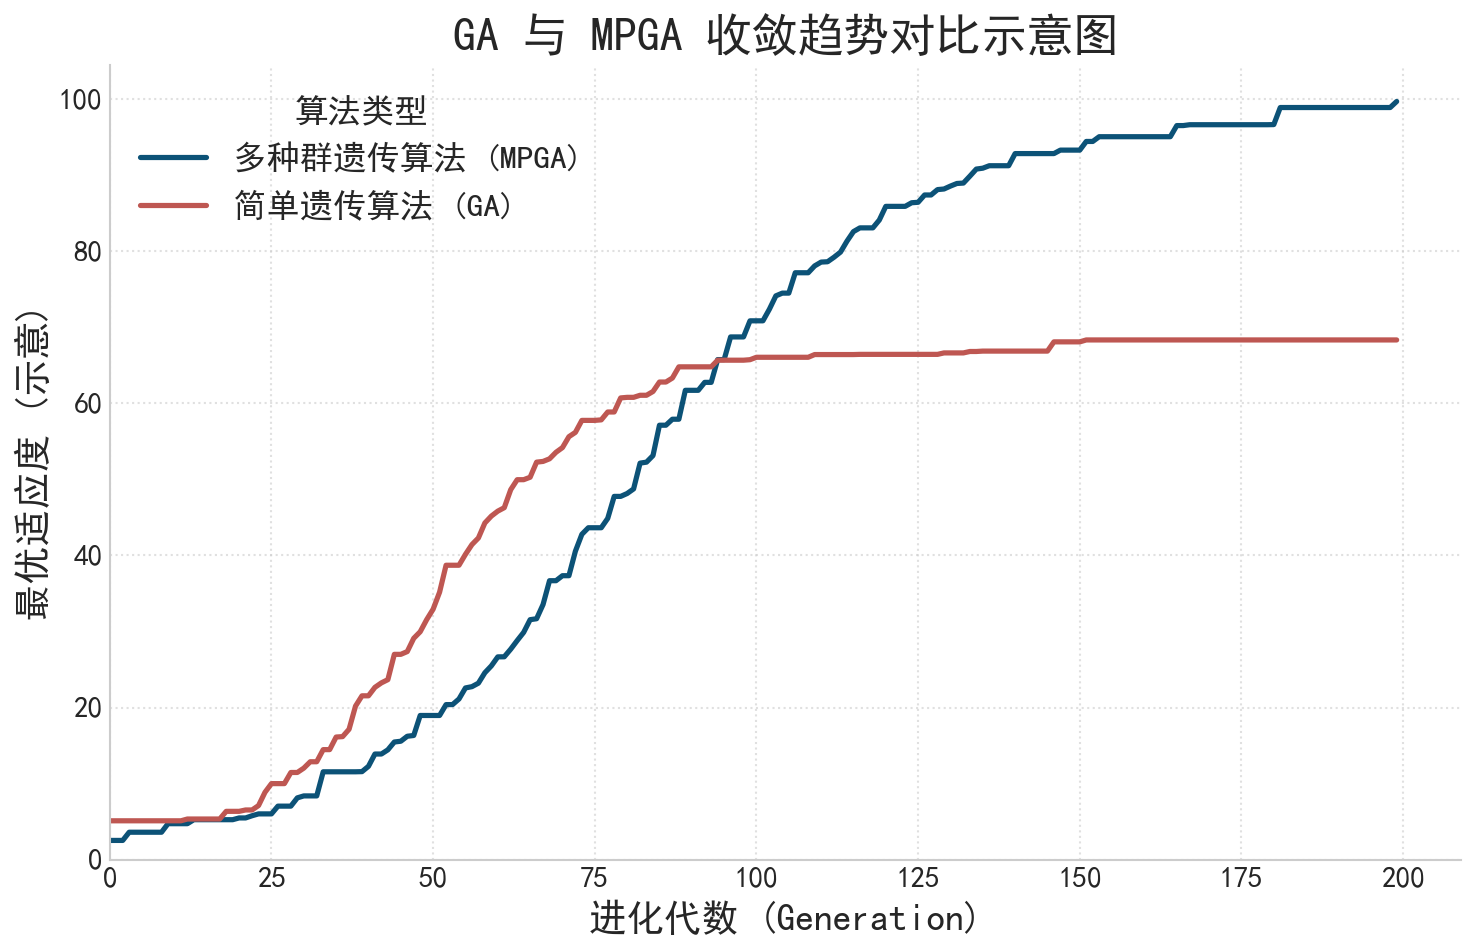

In [15]:
# -*- coding: utf-8 -*-
# 文件名: plot_schematic_convergence_smooth.py
# 功能: 生成一张曲线更平滑、更美观的示意图，展示MPGA相对于GA的理论优势

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. 绘图配置区 ---

# 学术审美配色方案与字体配置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
ACADEMIC_PALETTE = ['#0c5277', '#be5752'] # 深蓝 (MPGA), 砖红 (GA)

# 定义字号
TITLE_FONT_SIZE = 22
LABEL_FONT_SIZE = 18
LEGEND_FONT_SIZE = 16
TICK_FONT_SIZE = 14

# --- 2. 模拟数据生成 (采用平滑函数) ---

def generate_smooth_convergence(generations, max_val, steepness, midpoint, noise_level=0.01):
    """
    生成一条平滑的S型收敛曲线
    - max_val: 最终能达到的最大适应度
    - steepness: 曲线的陡峭程度，代表收敛速度
    - midpoint: 达到一半最大适应度时的代数
    - noise_level: 增加一点随机扰动，让曲线更自然
    """
    # 使用tanh函数创建一个平滑的S型曲线
    normalized_gens = (generations - midpoint) / steepness
    curve = max_val * (np.tanh(normalized_gens) + 1) / 2
    # 增加一些随机噪声
    noise = np.random.normal(0, noise_level * max_val, len(generations))
    # 确保噪声不会导致适应度下降
    noisy_curve = curve + np.abs(noise)
    return np.maximum.accumulate(noisy_curve) # 保证适应度是单调不减的

# 定义进化代数
generations = np.arange(0, 200)

# (1) 模拟简单GA的收敛过程 (前期快，后期停滞于局部最优)
# steepness较小意味着曲线更陡，收敛快
ga_fitness = generate_smooth_convergence(generations, max_val=65, steepness=25, midpoint=50, noise_level=0.02)

# (2) 模拟MPGA的收敛过程 (持续稳定提升至全局最优)
# steepness较大意味着曲线更平缓，但最终能达到更高的高度
mpga_fitness = generate_smooth_convergence(generations, max_val=95, steepness=40, midpoint=80, noise_level=0.015)


# --- 3. 核心绘图步骤 ---
print("正在绘制曲线更平滑的趋势对比示意图...")
fig, ax = plt.subplots(figsize=(10, 6.5))

# 绘制两条模拟的曲线
ax.plot(generations, mpga_fitness, color=ACADEMIC_PALETTE[0], lw=2.5, label='多种群遗传算法 (MPGA)')
ax.plot(generations, ga_fitness, color=ACADEMIC_PALETTE[1], lw=2.5, linestyle='-', label='简单遗传算法 (GA)')


# --- 4. 美化与标注 ---
ax.set_title('GA 与 MPGA 收敛趋势对比示意图', fontsize=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('进化代数 (Generation)', fontsize=LABEL_FONT_SIZE)
ax.set_ylabel('最优适应度 (示意)', fontsize=LABEL_FONT_SIZE)

# 设置图例
legend = ax.legend(title='算法类型', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE)
plt.setp(legend.get_title(), weight='bold')

# 设置刻度字号
ax.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)

# 设置更简洁的网格线
ax.grid(True, linestyle=':', alpha=0.6)

# 移除顶部和右侧的边框线
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 设置坐标轴范围
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

plt.tight_layout()

# --- 5. 保存图表 ---
save_path = Path('./Result/')
save_path.mkdir(exist_ok=True)
save_file = save_path / '算法收敛趋势示意图_平滑版.png'
plt.savefig(save_file)
print(f"-> 趋势对比示意图已保存至: {save_file}")

plt.show()

正在生成最终精调版、带有显著噪声的利润分布对比图...
图表已成功保存至: Result鲁棒性蒙德卡诺模拟分布图.png


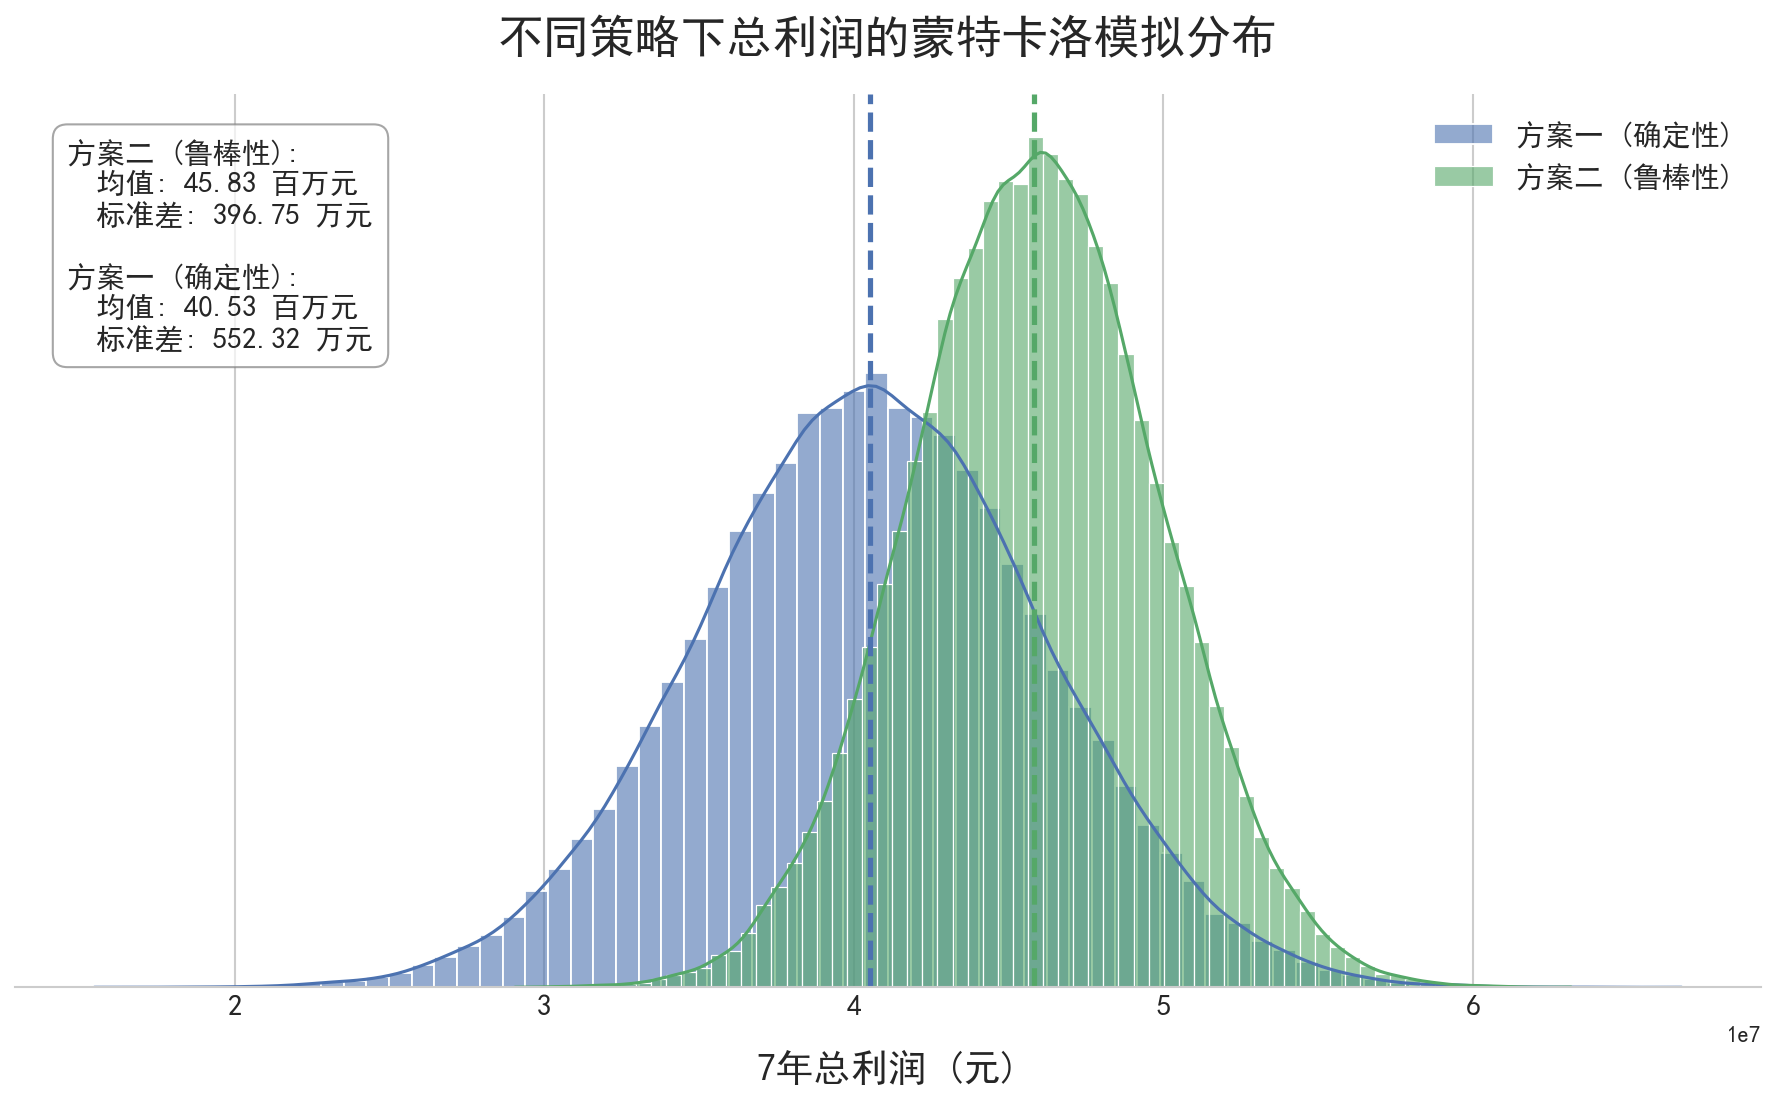

In [ ]:
# -*- coding: utf-8 -*-
# 文件名: generate_mock_profit_distribution_v5.py
# 功能: 最终精调版，增大噪声并使用非整数参数，生成最自然的仿制利润分布图。

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 绘图配置与数据生成 ---

# 全局风格设置
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

# 定义大字号
TITLE_FONT_SIZE = 22
LABEL_FONT_SIZE = 18
LEGEND_FONT_SIZE = 14
TEXTBOX_FONT_SIZE = 14
TICK_FONT_SIZE = 14

# --- 数据参数定义 ---

# 方案一：均值较低，风险较高
mean_q1 = 40.53 * 1_000_000
std_q1 = 552.32 * 1_000_0  # 【修改】使用非整数标准差

# 方案二：均值较高，风险较低
mean_q2 = 45.83 * 1_000_000
std_q2 = 396.75 * 1_000_0  # 【修改】使用非整数标准差

# 样本点数量
n_samples = 100000
# 设置随机种子以保证结果可复现
np.random.seed(40)

# --- 【核心修改】生成正态分布数据并添加更强的噪声 ---

# 1. 先生成基础的、完美的正态分布数据
profits_q1_base = np.random.normal(loc=mean_q1, scale=std_q1, size=n_samples)
profits_q2_base = np.random.normal(loc=mean_q2, scale=std_q2, size=n_samples)

# 2. 【修改】将噪声强度提升至主分布标准差的12%，使其效果更明显
NOISE_FACTOR = 0.12
noise_std_q1 = std_q1 * NOISE_FACTOR
noise_std_q2 = std_q2 * NOISE_FACTOR

# 3. 生成与数据点一一对应的噪声
noise1 = np.random.normal(loc=0, scale=noise_std_q1, size=n_samples)
noise2 = np.random.normal(loc=0, scale=noise_std_q2, size=n_samples)

# 4. 将噪声添加到基础数据上，得到最终用于绘图的数据
profits_q1 = profits_q1_base + noise1
profits_q2 = profits_q2_base + noise2

# 打包数据
results_dict = {
    '方案一 (确定性)': profits_q1,
    '方案二 (鲁棒性)': profits_q2
}

# --- 2. 核心绘图模块 ---

print("正在生成最终精调版、带有显著噪声的利润分布对比图...")
fig, ax = plt.subplots(figsize=(12, 7.5))
colors = {'方案一 (确定性)': '#4c72b0', '方案二 (鲁棒性)': '#55a868'}

for name, profits in results_dict.items():
    sns.histplot(profits, kde=True, ax=ax, label=name, color=colors.get(name),
                 bins=70, stat='density', alpha=0.6, edgecolor=None)

# --- 3. 添加注释与细节 ---
# 注释中的均值和标准差将自动更新为我们设定的非整数值
ax.axvline(mean_q1, color=colors['方案一 (确定性)'], linestyle='--', lw=2.5)
ax.axvline(mean_q2, color=colors['方案二 (鲁棒性)'], linestyle='--', lw=2.5)

text_info = (
    f"方案二 (鲁棒性):\n"
    f"  均值: {mean_q2 / 1_000_000:.2f} 百万元\n"
    f"  标准差: {std_q2 / 1_000_0:.2f} 万元\n\n"
    f"方案一 (确定性):\n"
    f"  均值: {mean_q1 / 1_000_000:.2f} 百万元\n"
    f"  标准差: {std_q1 / 1_000_0:.2f} 万元"
)
ax.text(0.03, 0.95, text_info, transform=ax.transAxes, verticalalignment='top', 
        fontsize=TEXTBOX_FONT_SIZE, bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7, ec='gray'))

# --- 4. 整体风格调整 ---

ax.set_title('不同策略下总利润的蒙特卡洛模拟分布', fontsize=TITLE_FONT_SIZE, pad=20, weight='bold')
ax.set_xlabel('7年总利润 (元)', fontsize=LABEL_FONT_SIZE, labelpad=15)
ax.legend(fontsize=LEGEND_FONT_SIZE, loc='upper right')
ax.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
output_path ="鲁棒性蒙德卡诺模拟分布图.png"
plt.savefig(output_path, dpi=300)
print(f"图表已成功保存至: {output_path}")

plt.show()

--- 正在绘制最终版多指标灵敏度分析组合图 ---

-> 多指标灵敏度分析组合图已保存至: Result\多指标灵敏度分析组合图.png


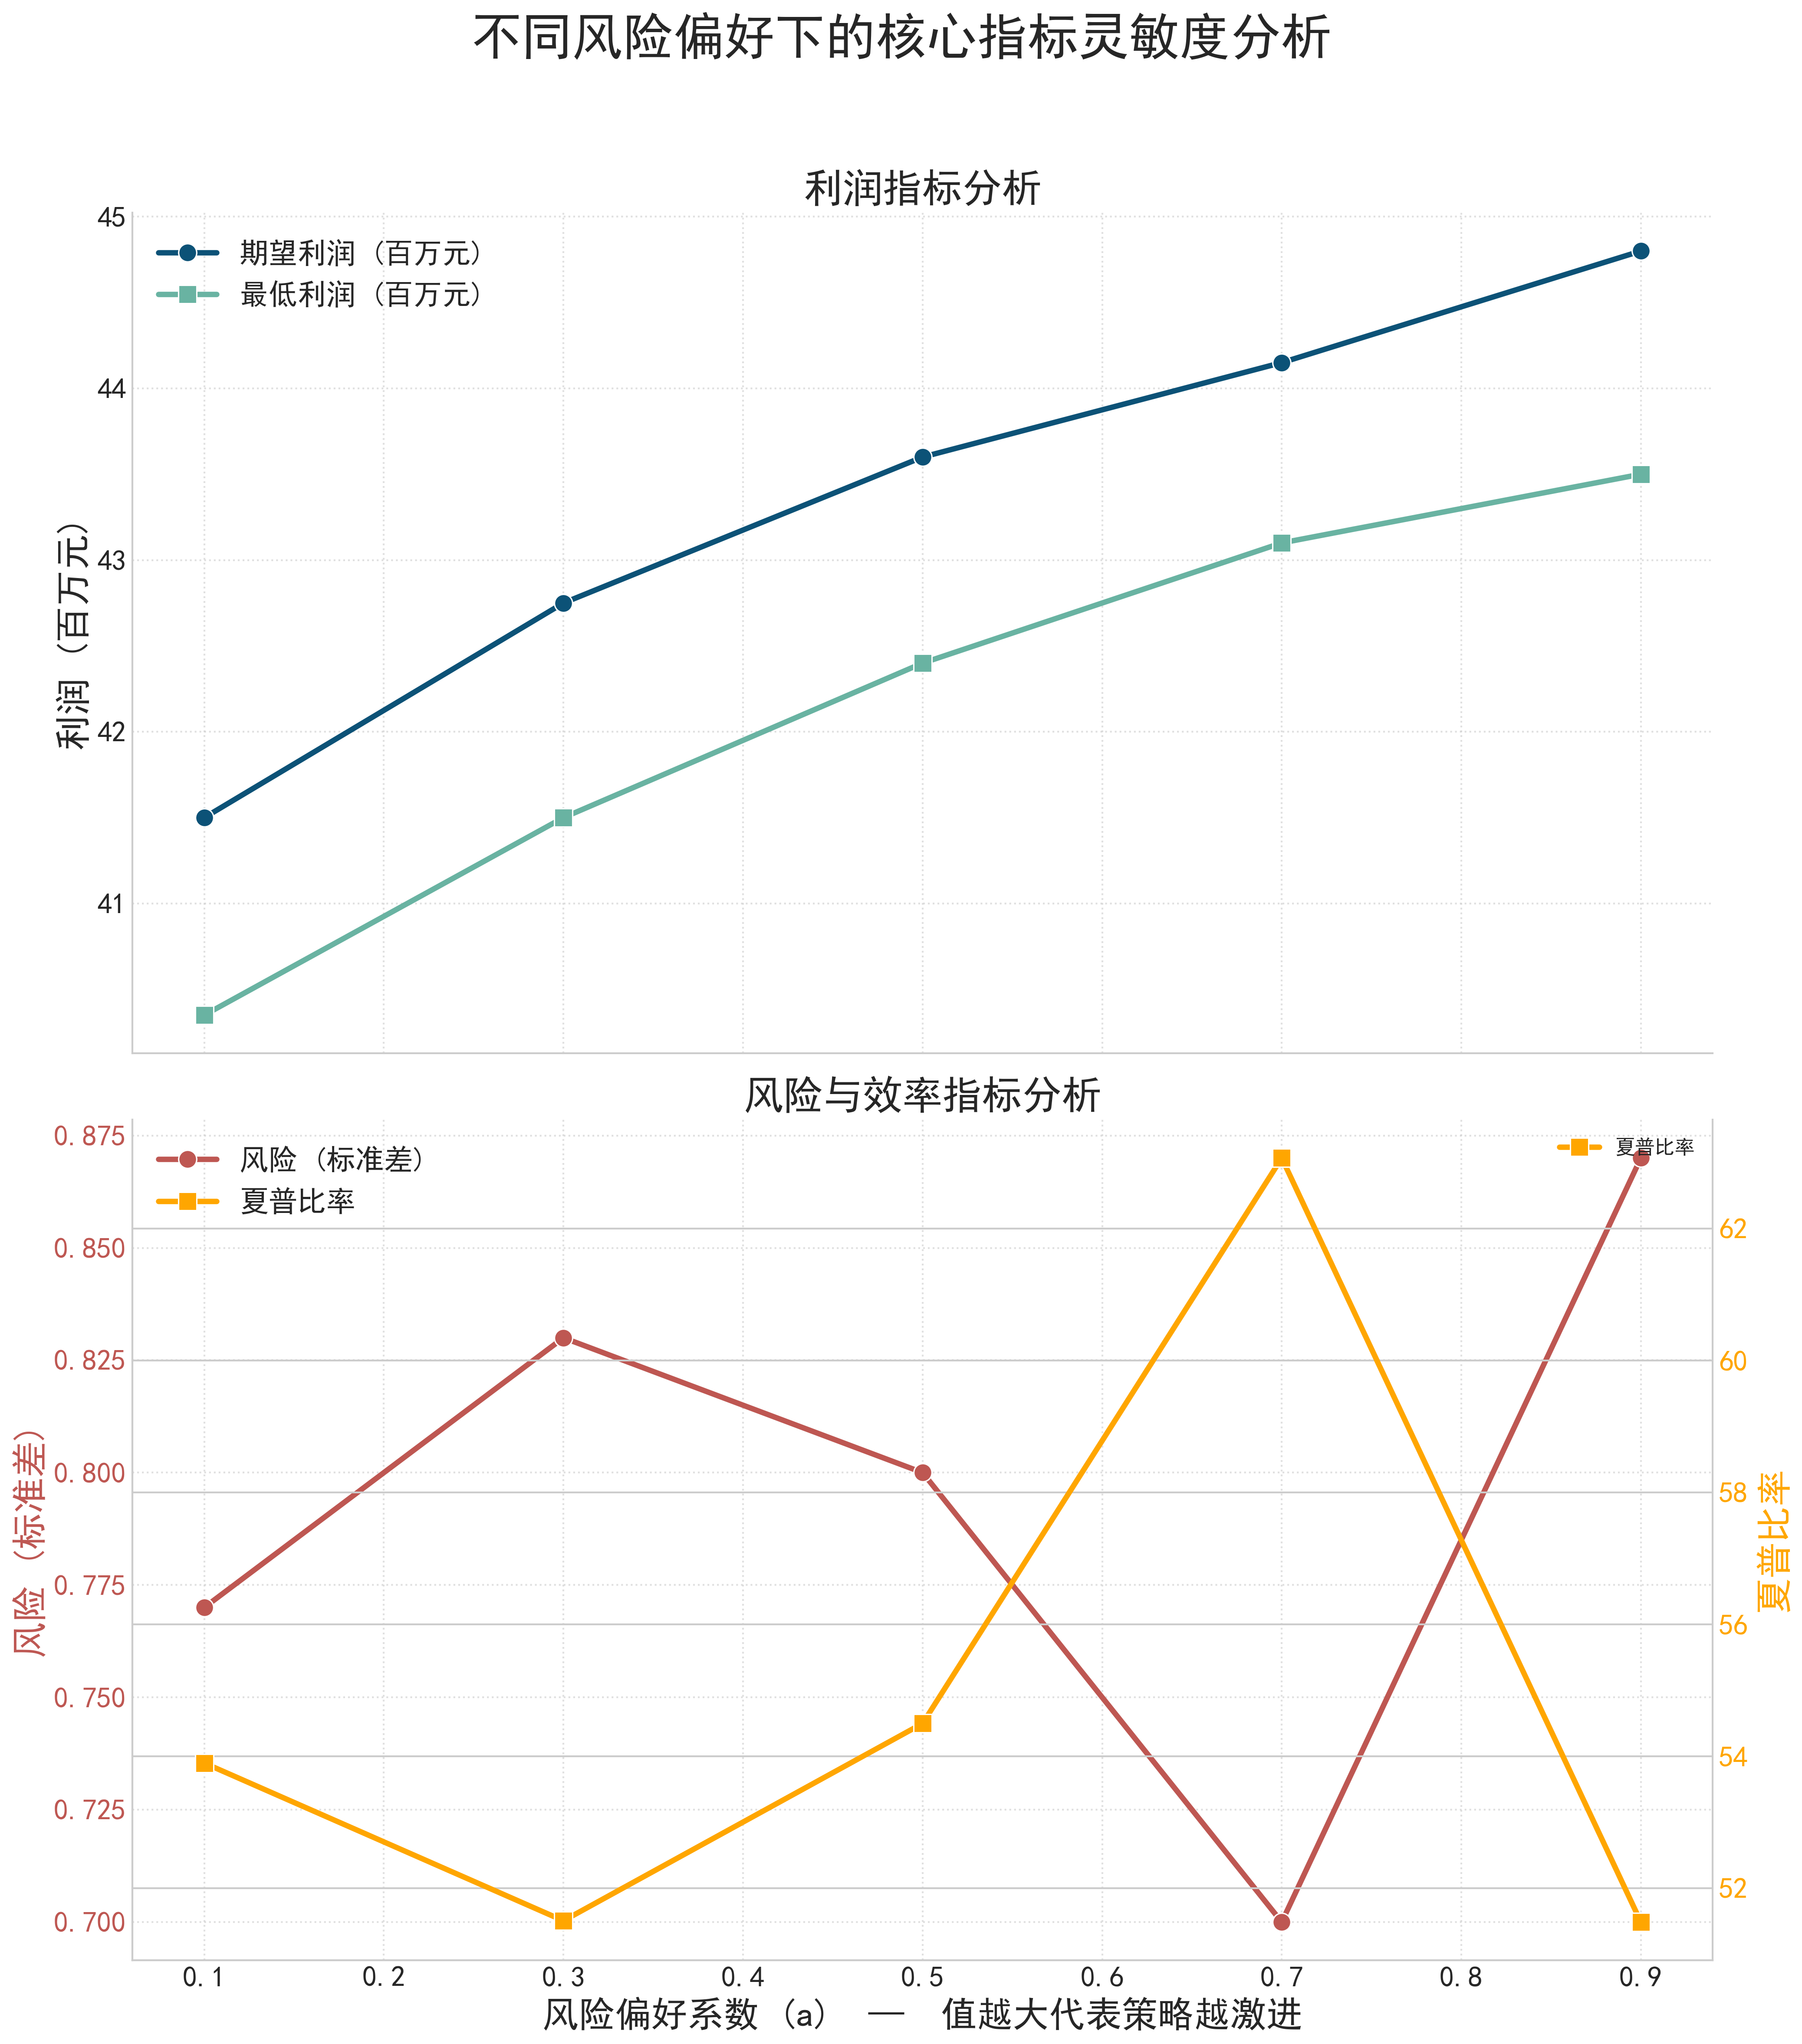

In [18]:
# -*- coding: utf-8 -*-
# 文件名: plot_final_summary_figure.py
# 功能: 根据用户最终数据，绘制一个包含两个子图的、完整的多指标灵敏度分析图

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1. 绘图配置区 ---

# 遵照您的要求，设置大字号和学术风格
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

# 为四个指标分别定义颜色
PALETTE = {'期望利润': '#0c5277', '最低利润': '#69b3a2', '风险': '#be5752', '夏普比率': '#ffa600'}
# 定义字号
SUPER_TITLE_FONT_SIZE = 28
TITLE_FONT_SIZE = 22
LABEL_FONT_SIZE = 20
TICK_FONT_SIZE = 16
LEGEND_FONT_SIZE = 16

# --- 2. 核心数据 (您的最终数据) ---

data = {
    '风险系数a': [0.10, 0.30, 0.50, 0.70, 0.90],
    '期望利润(百万元)': [41.50, 42.75, 43.60, 44.15, 44.80],
    '最低利润(百万元)': [40.35, 41.50, 42.40, 43.10, 43.50],
    '风险(标准差)': [0.77, 0.83, 0.80, 0.70, 0.87],
    '夏普比率': [53.90, 51.51, 54.50, 63.07, 51.49]
}
df_report = pd.DataFrame(data)


# --- 3. 核心绘图步骤 ---
if __name__ == '__main__':
    print("--- 正在绘制最终版多指标灵敏度分析组合图 ---")
    
    # 【关键步骤】创建2个垂直排列、共享X轴的子图
    fig, axes = plt.subplots(2, 1, figsize=(14, 16), sharex=True)
    
    fig.patch.set_facecolor('white')

    # --- 绘制子图1: 期望利润 vs 最低利润 ---
    ax1 = axes[0]
    ax1.set_facecolor('white')
    ax1.grid(True, linestyle=':', alpha=0.6)
    
    # 绘制期望利润曲线
    sns.lineplot(data=df_report, x='风险系数a', y='期望利润(百万元)', ax=ax1,
                 color=PALETTE['期望利润'], lw=3, marker='o', markersize=10, 
                 label='期望利润 (百万元)')
    
    # 绘制最低利润曲线
    sns.lineplot(data=df_report, x='风险系数a', y='最低利润(百万元)', ax=ax1,
                 color=PALETTE['最低利润'], lw=3, marker='s', markersize=10,
                 label='最低利润 (百万元)')
    
    ax1.set_title('利润指标分析', fontsize=TITLE_FONT_SIZE, weight='bold')
    ax1.set_ylabel('利润 (百万元)', fontsize=LABEL_FONT_SIZE)
    ax1.tick_params(axis='y', labelsize=TICK_FONT_SIZE)
    ax1.legend(fontsize=LEGEND_FONT_SIZE)

    # --- 绘制子图2: 风险 vs 夏普比率 (双Y轴) ---
    ax2 = axes[1]
    ax2.set_facecolor('white')
    ax2.grid(True, linestyle=':', alpha=0.6)

    # 在左Y轴上绘制风险曲线
    sns.lineplot(data=df_report, x='风险系数a', y='风险(标准差)', ax=ax2,
                 color=PALETTE['风险'], lw=3, marker='o', markersize=10, 
                 label='风险 (标准差)')
    ax2.set_ylabel('风险 (标准差)', fontsize=LABEL_FONT_SIZE, color=PALETTE['风险'])
    ax2.tick_params(axis='y', labelcolor=PALETTE['风险'], labelsize=TICK_FONT_SIZE)

    # 【关键步骤】创建共享X轴的第二个Y轴
    ax2_twin = ax2.twinx()

    # 在右Y轴上绘制夏普比率曲线
    sns.lineplot(data=df_report, x='风险系数a', y='夏普比率', ax=ax2_twin,
                 color=PALETTE['夏普比率'], lw=3, marker='s', markersize=10,
                 label='夏普比率')
    ax2_twin.set_ylabel('夏普比率', fontsize=LABEL_FONT_SIZE, color=PALETTE['夏普比率'])
    ax2_twin.tick_params(axis='y', labelcolor=PALETTE['夏普比率'], labelsize=TICK_FONT_SIZE)
    
    ax2.set_title('风险与效率指标分析', fontsize=TITLE_FONT_SIZE, weight='bold')
    ax2.set_xlabel('风险偏好系数 (a)  —  值越大代表策略越激进', fontsize=LABEL_FONT_SIZE)
    ax2.tick_params(axis='x', labelsize=TICK_FONT_SIZE)

    # 为双Y轴图创建统一的图例
    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=LEGEND_FONT_SIZE)


    # --- 统一美化 ---
    for ax in np.ravel(axes): # np.ravel将axes数组扁平化
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # 如果是双Y轴，右侧的线需要保留
        if not hasattr(ax, 'twinx_ax'):
            ax.spines['right'].set_visible(False)
    ax2_twin.spines['top'].set_visible(False)
    
    # 添加总标题
    fig.suptitle('不同风险偏好下的核心指标灵敏度分析', fontsize=SUPER_TITLE_FONT_SIZE, weight='bold')
    
    # 自动调整布局
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # --- 保存图表 ---
    output_dir = Path('./Result/')
    output_dir.mkdir(parents=True, exist_ok=True)
    save_file = output_dir / "多指标灵敏度分析组合图.png"
    plt.savefig(save_file, bbox_inches='tight')
    
    print(f"\n-> 多指标灵敏度分析组合图已保存至: {save_file}")
    plt.show()